# La qualité de l'air dans le métro parisien

In [1]:
%matplotlib inline
import numpy as np
import numpy.fft as fft
from matplotlib import pyplot as plt
import os
import urllib.request
import datetime
%pdb

Automatic pdb calling has been turned ON


### Importation des donnees

Telechargement / gestion de la copie locale

In [2]:
data_urls = {"chatelet": "https://data.ratp.fr/explore/dataset/qualite-de-lair-mesuree-dans-la-station-chatelet/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true",
             "auber": "https://data.ratp.fr/explore/dataset/qualite-de-lair-mesuree-dans-la-station-auber/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true",
             "roosevelt": "https://data.ratp.fr/explore/dataset/qualite-de-lair-mesuree-dans-la-station-franklin-d-roosevelt/download/?format=csv&timezone=Europe/Berlin&use_labels_for_header=true"}
data_files = {name: name+".csv" for name, url in data_urls.items()}

data_exists = all([os.path.exists(filename) for name, filename in data_files.items()])
timestamp_file = 'data_download_time'
if data_exists:
    timestamp = open(timestamp_file).read()
    print("Reusing data downloaded on: ", timestamp)
else:
    print("Downloading data on ", datetime.datetime.now())
    for name, url in data_urls.items():
        urllib.request.urlretrieve(url, data_files[name])
    with open(timestamp_file, 'w') as file:
        file.write(str(datetime.datetime.now()))

Reusing data downloaded on:  2018-06-25 11:40:12.689381


Lecture des donnees

In [3]:
import csv
data = {}
for name, filename in data_files.items():
    reader = csv.reader(open(filename), delimiter=';')
    headers = [f.upper() for f in reader.__next__()]
    data[name] = {field: [] for field in headers}
    for record in reader:
        for field, value in zip(headers, record):
            if field == "DATE/HEURE":
                value = datetime.datetime.strptime(value[:22]+value[23:], "%Y-%m-%dT%H:%M:%S%z")
            else:
                value = np.NaN if value == '' else float(value)
            data[name][field].append(value)
    for field, values in data[name].items():
        data[name][field] = np.array(values)

Attention: les données ne sont pas dans l'ordre chronologique !

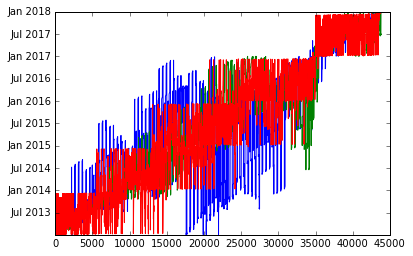

In [4]:
plt.plot(data['chatelet']['DATE/HEURE'])
plt.plot(data['auber']['DATE/HEURE'])
plt.plot(data['roosevelt']['DATE/HEURE'])

Trions-les !

In [5]:
for name in data.keys():
    index = np.argsort(data[name]['DATE/HEURE'])
    for field, values in data[name].items():
        data[name][field] = np.take(data[name][field], index)

Maintenant ça va mieux.

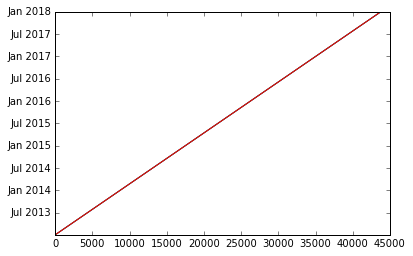

In [6]:
plt.plot(data['chatelet']['DATE/HEURE'])
plt.plot(data['auber']['DATE/HEURE'])
plt.plot(data['roosevelt']['DATE/HEURE'])

Combien de points avons-nous ?

In [7]:
for name in data.keys():
    print(name, len(data[name]['DATE/HEURE']))

roosevelt 43798
auber 43798
chatelet 43798


Les axes de temps sont les mêmes pour Châtelet et Auber...

In [8]:
all(data['chatelet']['DATE/HEURE'] == data['auber']['DATE/HEURE'])

True

... mais pas pour Roosevelt.

In [9]:
all(data['chatelet']['DATE/HEURE'] == data['roosevelt']['DATE/HEURE'])

False

Les étiquettes date/heure communes aux trois jeux de données sont celles qu'on trouve trois fois en total.

In [10]:
counters = {}
for name in data.keys():
    for t in data[name]['DATE/HEURE']:
        counters[t] = counters.get(t, 0) + 1

Nous ne gardons que les mesures simultanées.

In [11]:
for name in data.keys():
    mask = [counters[t] == 3 for t in data[name]['DATE/HEURE']]
    for field in data[name].keys():
        data[name][field] = np.repeat(data[name][field], mask)

In [12]:
print(all(data['chatelet']['DATE/HEURE'] == data['auber']['DATE/HEURE']),
      all(data['chatelet']['DATE/HEURE'] == data['roosevelt']['DATE/HEURE']))

True True


Combien de données ont survécu ?

In [13]:
for name in data.keys():
    print(name, len(data[name]['DATE/HEURE']))

roosevelt 43797
auber 43797
chatelet 43797


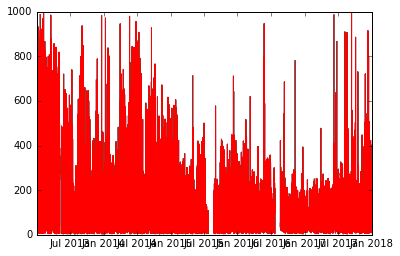

In [14]:
plt.plot(data['chatelet']['DATE/HEURE'], data['auber']['PM10'])
plt.plot(data['auber']['DATE/HEURE'], data['auber']['PM10'])
plt.plot(data['roosevelt']['DATE/HEURE'], data['auber']['PM10'])

In [15]:
np.corrcoef(data['auber']['PM10'], data['chatelet']['PM10'])

array([[ nan,  nan],
       [ nan,  nan]])